# PONCE_SALAFRANCA GENDER PREDICTION


## D. Gender Classification
Automatic gender classification has been used in many applications. The goal of this project is to classify
the gender of faces in an image. One can design a convolutional neural network or Transformer to achieve
this goal. Some tasks to consider:
1. Modify some previously published architectures e.g., increase the network depth, reducing their
parameters, etc. Explore more advanced techniques such as deformable convolution, dilated
convolution (dilation>1) or visual prompt tuning for Transformers.
2. Consider age and gender recognition simultaneously to take advantage of the gender-specific age
characteristics and age-specific gender characteristics inherent to images
3. Consider pre-training using the CelebA dataset
http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html


References
1. G. Levi and T. Hassner, “Age and gender classification using convolutional neural networks.” in
IEEE Conf. on Computer Vision and Pattern Recognition (CVPR) workshops, 2015
2. Z. Liu and P. Luo and X. Wang, and X. Tang, “Deep learning face attributes in the wild,” in
International Conference on Computer Vision (ICCV), 2015

### 1.0 We do import all the important packages for the work.

We are going to use several packages for this assignement

In [6]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import KFold

import cv2
import random
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.ops import DeformConv2d
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import EfficientNetB5
from tensorflow.keras import optimizers
from tensorflow import keras

import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

import torch
from torch import nn, optim

import tensorflow as tf
print(tf.__version__)
tf.config.run_functions_eagerly(False)

2.16.1


### 1.1 We know import all the data usefull for the work

In [7]:
ADIENCE_PATH = './Adience'
all_folds={}
for i in range(5):
    all_folds[i]=pd.read_csv(os.path.join(ADIENCE_PATH, f'fold_{i}_data.txt'),sep = "\t" )
total_data = pd.concat([all_folds[i] for i in range(5)],ignore_index=True)

### 1.2 Preprocessing of the data 


In [8]:
total_data.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


We can observe that we have 19370 entries of data. However, only 18591 have a value for gender and 18622 for age. We need to look into that in the future, as the may not be useful for training/testing/validation. As we are going to work with these to variables (age and gender) let's check how the distribution is across the data. 

Also we can check that the possible values for gender are 'f' (female), 'm' (male) and 'u' (undefined). For age, we can observe that we have a mix of individual values and intervals. In this part we will make the following changes:
 - Drop all the rows that contain NaN values (in any column) of the data set as they are not interesting and won't lead to ueful information.
 - Group age by intervals which make sense. On the original data set we have different entries for example for (0,2) and '2' which should be in the same interval.
 - In the gender variable we will need to drop 'u', as it is not useful beacuse we are trying to classify between male and female.
 - Joining the two columns user_id and original_image, as it is just the way in which the pictures are stored in the data set. We can combine them to create a path.

In [10]:
df = total_data[['age', 'gender']].copy()
img_path = []

for row in total_data.iterrows():
    path = f"{ADIENCE_PATH}/faces/"+row[1].user_id+"/coarse_tilt_aligned_face."+str(row[1].face_id)+"."+row[1].original_image
    img_path.append(path)
df['img_path'] = img_path

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       19370 non-null  object
 1   gender    18591 non-null  object
 2   img_path  19370 non-null  object
dtypes: object(3)
memory usage: 454.1+ KB


Firstly, we will combine user_id and original_image into a new variable named image_path which will contain the path in the folder to the picture described by the data:

#### We do the mapping of age and gender

Third, we will group age old values into intervals. Unfortunatley its impossible to make the intervals have the same length as we are constrained by some of them were already given and are of varying lenghts. We tried keeping them as short as possible while still being an interval:

In [11]:
age_mapping = {'(0, 2)': 'baby', '2': 'baby', '(4, 6)': 'baby', '3': 'baby',
               '(15, 20)': 'ados', '22': 'ados', '13': 'ados', '23': 'ados', '(8, 23)': 'ados',  '(8, 12)': 'ados',
                '(25, 32)': 'young', '(27, 32)': 'young', '29': 'young', '32': 'young', '35': 'young',
                '36': 'adult', '34': 'adult',  '(38, 43)': 'adult', '(38, 48)': 'adult', '45': 'adult', 
                '(38, 42)': 'adult', '42': 'adult', '46': 'adult', '(48, 53)': 'adult',
                '55': 'adult', '58': 'adult', '57': 'adult', '56': 'adult', '(60, 100)': 'adult'
    
}
age_mapping_dict = {key: value for key, value in age_mapping.items()}
drop_labels = []
for idx, each in enumerate(df.age):
    if each == 'None':
        drop_labels.append(idx)
    else:
        df.age.loc[idx] = age_mapping_dict[each]

df = df.drop(labels=drop_labels, axis=0) #droped None values
df.age.value_counts(dropna=False)

young    5388
baby     4649
adult    4405
ados     4180
Name: age, dtype: int64

Second, we drop the NaNs values as we can't work with them. This function will search for NaN's in any column and delete the complete row where they were stored:

Fourth, we will eliminate the 'u' values of the gender variable as they are not associated with either males or females and the objective of this work is to distinguish between them:

In [12]:
df = df.dropna()
du = df[df.gender != 'u'].copy()
du.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17452 entries, 0 to 19345
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       17452 non-null  object
 1   gender    17452 non-null  object
 2   img_path  17452 non-null  object
dtypes: object(3)
memory usage: 545.4+ KB


Lastly, we will create some mapping of both age and gender. We will map gender as 0 (female) and 1 (male) and age with values from 0 to 8 for the intervals created:

In [13]:
gender_to_label_map = {
    'f' : 0,
    'm' : 1
}

age_to_label_map = {
    'baby'  :0,
    'ados' :1,
    'young':2,
    'adult':3
}

# label_to_age_map = {value: key for key, value in age_to_label_map.items()}
# label_to_gender_map = {value: key for key, value in gender_to_label_map.items()}

du['age'] = du['age'].apply(lambda age: age_to_label_map[age])
du['gender'] = du['gender'].apply(lambda g: gender_to_label_map[g])

du.head()

,age,gender,img_path
0,2,0,./Adience/faces/30601258@N03/coarse_tilt_align...
1,2,1,./Adience/faces/30601258@N03/coarse_tilt_align...
2,2,0,./Adience/faces/30601258@N03/coarse_tilt_align...
3,2,1,./Adience/faces/30601258@N03/coarse_tilt_align...
4,2,1,./Adience/faces/30601258@N03/coarse_tilt_align...


In [16]:

combined_to_label_map = {'00'  :0,'01' :1,'02':2,'03':3,'10':4,'11':5,'12':6,'13':7}
label_map = {'baby woman'  :0,'ados woman' :1,'young woman':2,'adult woman':3,'bay man':4,
                         'baby ados':5,'young man':6,'adult man':7}     
du['combined'] = du['gender'].astype('str') + du['age'].astype('str')
du['combined'] = du['combined'].apply(lambda g: combined_to_label_map[g])
du.head()

,age,gender,img_path,combined
0,2,0,./Adience/faces/30601258@N03/coarse_tilt_align...,2
1,2,1,./Adience/faces/30601258@N03/coarse_tilt_align...,6
2,2,0,./Adience/faces/30601258@N03/coarse_tilt_align...,2
3,2,1,./Adience/faces/30601258@N03/coarse_tilt_align...,6
4,2,1,./Adience/faces/30601258@N03/coarse_tilt_align...,6


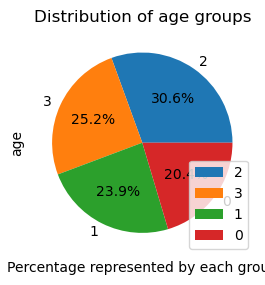

In [17]:
plt.subplot(1,2,1)
plt.title('Distribution of age groups')
plt.xlabel('Percentage represented by each group')
du.age.value_counts().plot.pie(autopct = "%1.1f%%")
plt.legend()

Text(0.5, 0, 'Number of people')

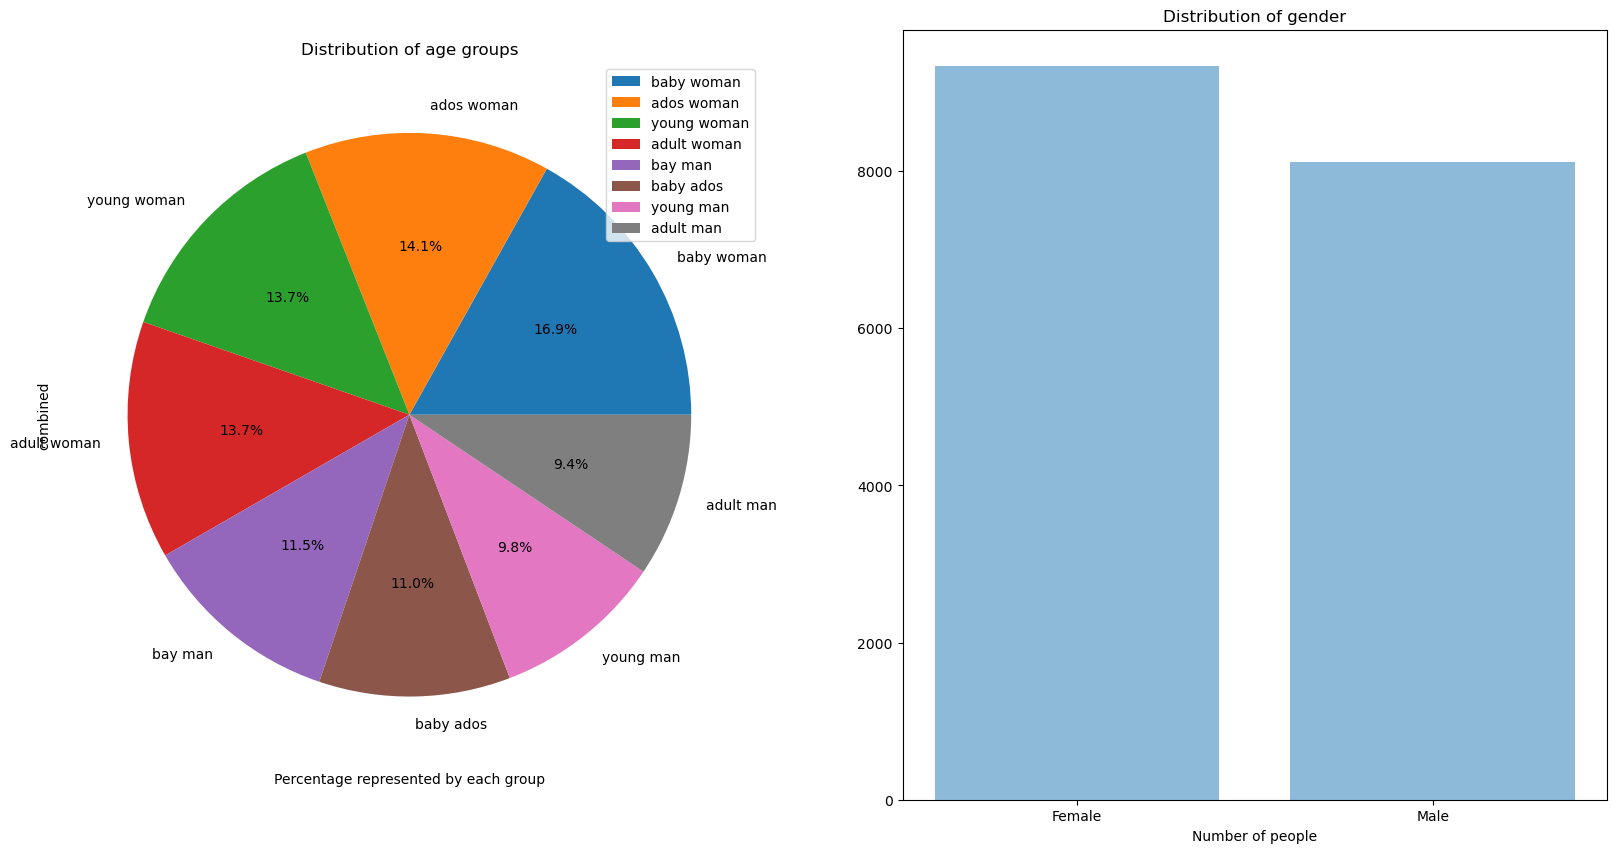

In [18]:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.title('Distribution of age groups')
plt.xlabel('Percentage represented by each group')
du.combined.value_counts().plot.pie(autopct = "%1.1f%%",labels = label_map)
plt.legend()
plt.subplot(1,2,2)
gender = ['Female','Male']
plt.bar(gender, du.gender.value_counts(), align = 'center', alpha = 0.5)
plt.title('Distribution of gender')
plt.xlabel('Number of people')

In [23]:
male_data.age


AttributeError: 'Series' object has no attribute 'categories'

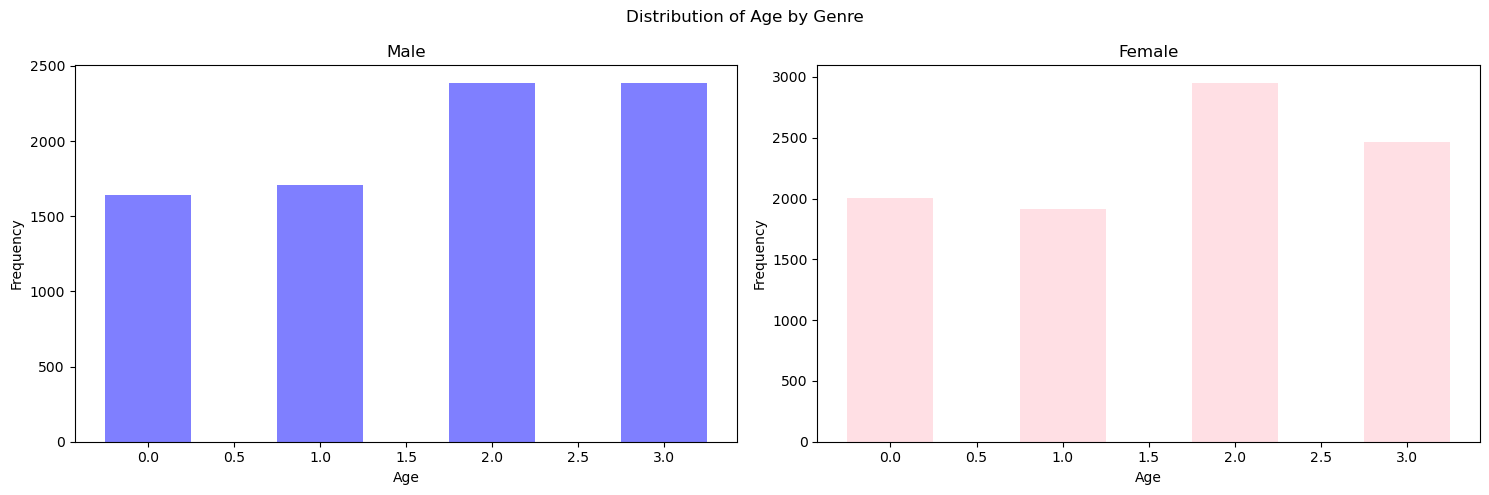

In [24]:
male_data = du[du.gender == 1].copy()
female_data = du[du.gender == 0].copy()
# Create subplots for each genre
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot histograms for each genre
axs[0].bar(male_data.age.unique(), male_data.age.value_counts(), alpha=0.5, color='blue', width=0.5)
axs[0].set_title('Male')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Frequency')

axs[1].bar(female_data.age.unique(), female_data.age.value_counts(), alpha=0.5, color='pink', width=0.5)
axs[1].set_title('Female')
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Frequency')


plt.suptitle('Distribution of Age by Genre')
plt.tight_layout()
plt.show()

As we can see the gender is pretty equally distributed which is good for the training of the future models. However, the age has a few groups which are very small. In the future, we will have to see if errors are in this groups whoch could be due to small training group for this age groups. in that case we will reorganise.

### 1.3 We create the Datasets for training, testing and validation.

The X part will, for the moment, contain de image path. Y will contain the gender of the person in the image. we will divide the dataset into a 75:25 training to testing split:

In [14]:
X =du[['img_path']]
y = du[['combined']]
y2 = du[['gender','age']]

from sklearn.model_selection import train_test_split

Xtrain, X_temp, ytrain, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
Xvalidation, Xtest, yvalidation, ytest = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print('Train data shape {}'.format(Xtrain.shape))
print('Validation data shape{}'.format(Xvalidation.shape))
print('Test data shape {}'.format(Xtest.shape))

Train data shape (12216, 1)
Validation data shape(2618, 1)
Test data shape (2618, 1)


This cell was very usefull when trying some models. To reduce the amount of data and the time o executin in a first stone of the implementation of the model.

In [15]:
# Xtrain = Xtrain[:2000]
# Xtest = Xtest[:2000]
# Xvalidation = Xvalidation[:2000]
# ytrain = ytrain[:2000]
# ytest = ytest[:2000]
# yvalidation = yvalidation[:2000]

### 1.4 Resizing of images

We will create different data sets with different image reduction, so in the futrue we can compare model performance:

In [119]:
train_images = []
test_images = []
validation_images = []

for row in Xtrain.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))   # Resize the image
    data = np.asarray(image)
    # TODO: np.float
    train_images.append(data)

for row in Xtest.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))  # Resize the image
    data = np.asarray(image)
    test_images.append(data)
    
for row in Xvalidation.iterrows():
    image = Image.open(row[1].img_path)
    image = image.resize((227, 227))  # Resize the image
    data = np.asarray(image)
    validation_images.append(data)

train_images = np.asarray(train_images)
test_images = np.asarray(test_images)
validation_images = np.asarray(validation_images)

print('Train images shape {}'.format(train_images.shape))
print('Test images shape {}'.format(test_images.shape))
print('Validation images shape {}'.format(validation_images.shape))

Train images shape (12216, 227, 227, 3)
Test images shape (2618, 227, 227, 3)
Validation images shape (2618, 227, 227, 3)


### 1.4 Creation of the Model



We use the same model created and optimized for the gender recognition.

In [17]:
batch_size = 5
epochs =200
target_size = (227, 227) # (64, 64)
input_shape = (227, 227, 3) #(64, 64, 3)

# random seed
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

adam = 0.001
fre = -20
FC = 2048
E = 1
patience = 5
verbose = 1
factor = 0.50
min_lr = 0.0001
steps_per_epoch = 256
validation_steps = 256

drop_out_rate = 0.5

In [18]:
# calculate schedule drop based on epoch supplied
# paper said drop to 1e-4 when 10k epochs which is equivalent to drop 1e-3 by 10% which is 1e-4
import math

def step_decay(epoch):
    init_lrate = 1e-3 
    drop = 0.1
    epochs_drop = 10000
    lrate = init_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
    
weight_init = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01, seed=SEED)

In [19]:
# Define baseline model builder
def build_LeviHassner():
    model = keras.models.Sequential()
    
    # conv1: 96 filters, 7x7 kernel, stride=4, valid padding
    # max pooling with 3x3 kernel, stride=2
    # local response normalization
    model.add(Conv2D(96, (7,7), input_shape=input_shape, strides=4, padding='valid', 
                     activation='relu', kernel_initializer=weight_init))
    model.add(MaxPool2D(pool_size=(3, 3), strides=2, padding='same'))
    model.add(keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(input=x, alpha=0.0001, beta=0.75)))
    
    # conv2: 256 filters, 5x5 kernel and relu, padding=same
    # max pooling with 3x3 kernel, stride=2
    # local response normalization
    model.add(Conv2D(256, (5,5), padding='same', activation = 'relu', kernel_initializer=weight_init))
    model.add(MaxPool2D(pool_size = (3, 3), strides = 2,padding = 'same'))
    model.add(keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(input=x, alpha=0.0001, beta=0.75)))
    
    # conv3: 384 filters, 3x3 kernel and relu, padding=same
    # max pooling with 3x3 kernel, stride=2
    model.add(keras.layers.Conv2D(384,(3,3),padding='same',activation='relu',kernel_initializer=weight_init))
    model.add(keras.layers.MaxPool2D(pool_size=(3,3),strides=2,padding='same'))
    
    # flatten
    model.add(Flatten())
    
    # fc1 + dropout
    model.add(Dense(512, activation="relu", kernel_initializer=weight_init))
    model.add(Dropout(0.5))
    
    # fc2 + dropout
    model.add(Dense(512, activation='relu', kernel_initializer=weight_init))
    model.add(Dropout(0.5))
    
    # fc3
    model.add(Dense(10, activation ='sigmoid', kernel_initializer=weight_init))
    
    # compile the model
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-3, momentum=0.0),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    return model

In [20]:
from tensorflow.keras.utils import plot_model

model = build_LeviHassner()
model.summary()

C:\Users\jaime\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 56, 56, 96)          │          14,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 28, 28, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 28, 28, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 7, 7, 384)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18816)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       9,634,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,416,074 (43.55 MB)

 Trainable params: 11,416,074 (43.55 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
def get_call_backs():

    lrate = keras.callbacks.LearningRateScheduler(step_decay)
    
    mcp = ModelCheckpoint('model.keras')

    es = EarlyStopping(verbose=verbose, patience=patience)
    
    return [lrate, mcp, es]

In [22]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### 1.5 We execute the model 

In [23]:
history = model.fit(
    train_images, ytrain, 
    batch_size=batch_size, 
    epochs=epochs, 
    validation_data=(test_images, ytest), 
    callbacks=get_call_backs())

Epoch 1/200
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 293s 119ms/step - accuracy: 0.1504 - loss: 2.1346 - val_accuracy: 0.1925 - val_loss: 2.0689 - learning_rate: 0.0010
Epoch 2/200
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 293s 120ms/step - accuracy: 0.1809 - loss: 2.0506 - val_accuracy: 0.2227 - val_loss: 1.9554 - learning_rate: 0.0010
Epoch 3/200
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 293s 120ms/step - accuracy: 0.2396 - loss: 1.9232 - val_accuracy: 0.2865 - val_loss: 1.7567 - learning_rate: 0.0010
Epoch 4/200
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 295s 121ms/step - accuracy: 0.3081 - loss: 1.7574 - val_accuracy: 0.3407 - val_loss: 1.6323 - learning_rate: 0.0010
Epoch 5/200
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 294s 120ms/step - accuracy: 0.3600 - loss: 1.6312 - val_accuracy: 0.4053 - val_loss: 1.4903 - learning_rate: 0.0010
Epoch 6/200
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 322s 120ms/step - accuracy: 0.4004 - loss: 1.4992 - val_accuracy: 0.4450 - val_loss: 1.3650 - learning_rate: 0.0010
Epoch 7/200
2444/2444 ━━━━━━━━━━━━━━━━━━━━ 297

In [1]:
history = {
    'accuracy': [0.1504, 0.1809, 0.2396, 0.3081, 0.3600, 0.4004, 0.4410, 0.4905, 0.5351, 0.5793, 0.6085, 0.6461, 0.6790, 0.7266, 0.7498, 0.7758, 0.7965, 0.8178, 0.8435],
    'loss': [2.1346, 2.0506, 1.9232, 1.7574, 1.6312, 1.4992, 1.3686, 1.2547, 1.1441, 1.0446, 0.9612, 0.8780, 0.7961, 0.7094, 0.6373, 0.5777, 0.5150, 0.4676, 0.4125],
    'val_accuracy': [0.1925, 0.2227, 0.2865, 0.3407, 0.4053, 0.4450, 0.4882, 0.5225, 0.5584, 0.5794, 0.5791, 0.6123, 0.6028, 0.6478, 0.6451, 0.6711, 0.6868, 0.6803, 0.6738],
    'val_loss': [2.0689, 1.9554, 1.7567, 1.6323, 1.4903, 1.3650, 1.2506, 1.1851, 1.0962, 1.0654, 1.0991, 1.0006, 1.0429, 0.9457, 1.0152, 0.9591, 0.9467, 0.9951, 1.0139],
    'learning_rate': [0.001] * 19  # Assuming learning rate was constant at 0.001
}


In [35]:
test_loss, test_acc = model.evaluate(validation_images, yvalidation, verbose=2)
print(test_acc)

82/82 - 10s - 124ms/step - accuracy: 0.6799 - loss: 1.0117
0.6799083352088928


### 1.6 Plotting accuracies and losses

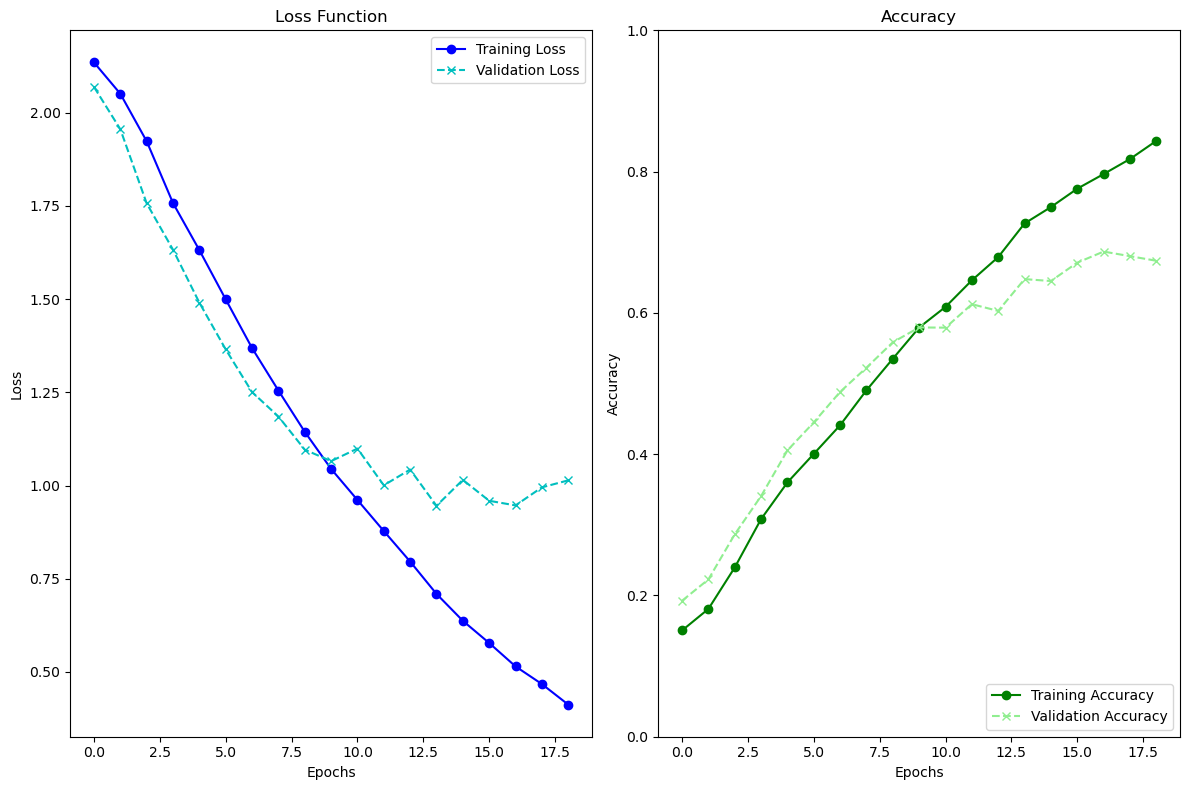

In [4]:
import matplotlib.pyplot as plt

# Assuming history contains the training history data for both loss and accuracy

# Plotting Loss
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed

plt.subplot(1, 2, 1)  # Create subplot for loss
plt.plot(history['loss'], label='Training Loss', color='blue', linestyle='-', marker='o')  # Customize line style and marker
plt.plot(history['val_loss'], label='Validation Loss', color='c', linestyle='--', marker='x')  # Customize line style and marker
# plt.axhline(y=test_loss, color='red', linestyle=':', label='Test Loss')
plt.title('Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(False)  # Add grid lines
plt.legend(loc='upper right')  # Adjust legend position

# Plotting Accuracy
plt.subplot(1, 2, 2)  # Create subplot for accuracy
plt.plot(history['accuracy'], label='Training Accuracy', color='green', linestyle='-', marker='o')  # Customize line style and marker
plt.plot(history['val_accuracy'], label='Validation Accuracy', color='lightgreen', linestyle='--', marker='x')  # Customize line style and marker
# plt.axhline(y=test_acc, color='red', linestyle=':', label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(False)  # Add grid lines
plt.legend(loc='lower right')  # Adjust legend position
plt.ylim([0, 1])  # Set y-axis limits to 0 and 1

plt.tight_layout()  # Improve spacing
plt.show()


### 1.7 Testing

In [24]:
test_loss, test_acc = model.evaluate(validation_images, yvalidation, verbose=2)
print(test_acc)

82/82 - 13s - 157ms/step - accuracy: 0.6738 - loss: 1.0138
0.6737967729568481


### 1.8 Some predictions and checking


In [120]:
predictions = model.predict(validation_images)

82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 138ms/step


In [128]:
predictions2 = np.argmax(predictions,axis = 1)


In [129]:
yvalidation2 = yvalidation.values
yvalidation2 = np.squeeze(yvalidation2)

In [124]:
age_to_label_maprev = {
    0:'woman baby'  ,
    1:'woman ados',
    2:'woman young',
    3:'woman adult',
    4:'man baby',
    5:'man ados',
    6:'man young', 
    7:'man adult'
    
}

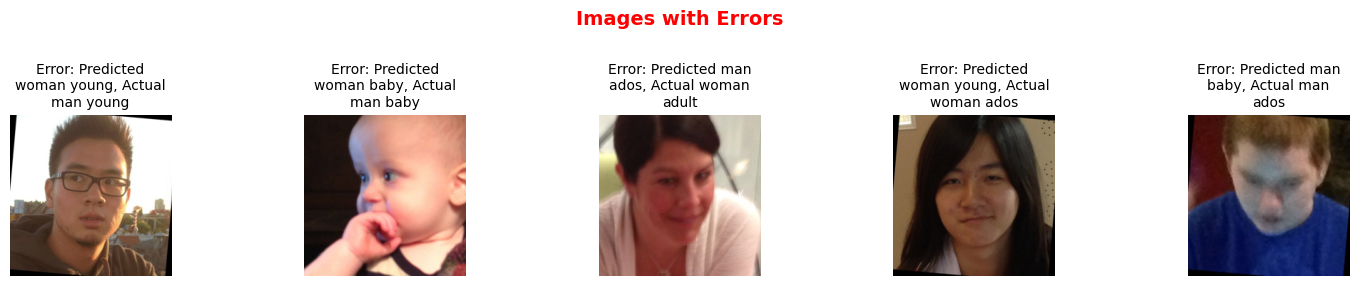

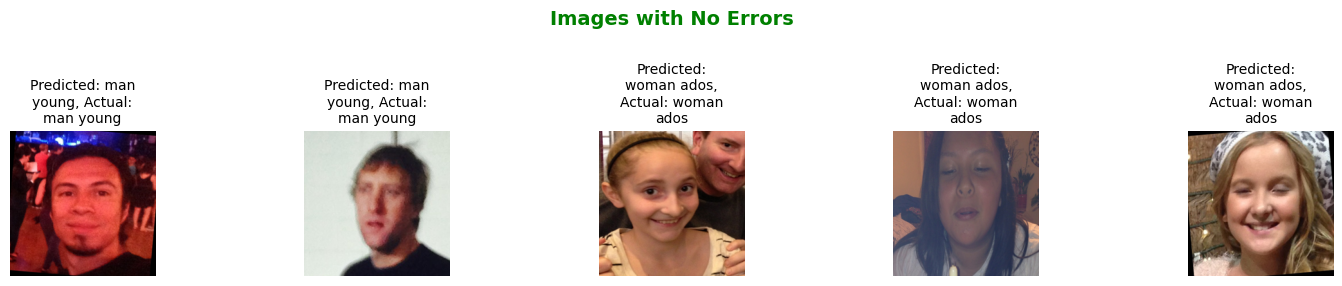

In [127]:
import matplotlib.pyplot as plt
import textwrap

# Assuming test_images and ytest are your test data and labels
# Applying threshold of 0.5 for binary classification
actual_labels = yvalidation2
# Find indices where predictions match actual labels (no errors)
correct_indices = np.where(predictions2 == yvalidation2)[0]

# Find indices where predictions do not match actual labels (errors)
error_indices = np.where(predictions2 != actual_labels)[0]

# random_correct_indices = np.random.choice(correct_indices, 3, replace=False)
# random_error_indices = np.random.choice(error_indices, 3, replace=False)

# Plotting images with errors
plt.figure(figsize=(15, 3))
for i, idx in enumerate(error_indices[:5]):
    plt.subplot(1, 5, i + 1)
    plt.imshow(validation_images[idx], cmap='gray')  # Assuming grayscale images
    title_text = f'Error: Predicted {age_to_label_maprev[int(predictions2[idx])]}, Actual {age_to_label_maprev[int(yvalidation2[idx])]}'
    plt.title('\n'.join(textwrap.wrap(title_text, width=20)), fontsize=10)  # Wrap the title
    plt.axis('off')
plt.suptitle('Images with Errors', fontsize=14, fontweight='bold', color='red')
plt.tight_layout(pad=2.0)
plt.show()

# Plotting images with no errors
plt.figure(figsize=(15, 3))
for i, idx in enumerate(correct_indices[:5]):
    plt.subplot(1, 5, i + 1)
    plt.imshow(validation_images[idx])  # Assuming grayscale images
    title_text = f'Predicted: {age_to_label_maprev[int(predictions2[idx])]}, Actual: {age_to_label_maprev[int(yvalidation2[idx])]}'
    plt.title('\n'.join(textwrap.wrap(title_text, width=15)), fontsize=10)  # Wrap the title
    plt.axis('off')
plt.suptitle('Images with No Errors', fontsize=14, fontweight='bold', color='green')
plt.tight_layout(pad=2.0)
plt.show()
